> ### EEE3314-02: Introduction to Artificial Intelligence

# Assignment \# VIII: Convolutional Neural Networks

<div style="text-align: right"> **Due date: Dec. 21, 2019.** </div> 
<div style="text-align: right"> **Please upload your file @ yscec by 8 PM in the form of [ID_Name.zip].** </div> 
<div style="text-align: right"> Wonkyung Lee (이원경): <a href="mailto:leewk92@yonsei.ac.kr">leewk92@yonsei.ac.kr</a> </div>
<div style="text-align: right"> Geon Lee (이건): <a href="mailto:2015142195@yonsei.ac.kr"> 2015142195@yonsei.ac.kr</a> </div>

### *Assignement Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <h4><span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically. **</span> </h4>

### *Collaboration policy:*
- You may discuss the questions.   
- Each student writes their own answers.   
- **Write on your homework anyone with whom you collaborate.**   
- Each student must write their own code for the programming part (**if not you will get a F grade**).

<h2><span style="color:blue">[Insert your ID HERE] [Insert your name HERE]</span> </h2>

In [1]:
%load_ext autoreload
%autoreload 2

import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2019-12-04 01:50:59.933890


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/My Drive/Colab

# PyTorch Tutorial
PyTorch is one of the latest deep learning framework developed by Facebook, and open sourced on GitHub since 2017. You can read more about its development in the research paper "Automatic Differentiation in PyTorch." PyTorch is gaining popularity for its simplicity, ease of use, dynamic computational graph and efficient memory usage. (reference : https://builtin.com/data-science/pytorch-vs-tensorflow)

## Example: PyTorch implementation for Assignment 7   

Recall assignment 7 which contains a classification problem of *moons* dataset from sklearn.datasets. In assignment 7, we implemented forward and backward propagation using numpy and trained a neural network with the following configuration.
- Model & training settings of assignment 7.
 - Input size: 2
 - the number ot hidden units : [10, 10] 
 - Output size: 2
 - Activations : [ReLU, Sigmoid, Softmax]
 - Loss function: Cross entropy loss
 - Optimizer: Gradient descent
 - Learning rate = 0.001
 - Number of epochs = 50000
 
Let's reproduce it by using pytorch framework. First, load *moons* dataset from sklearn.dataset and visualize the samples.

In [2]:
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "" # We use CPUs for training models.

np.random.seed(0)
# dataset
X, y = sklearn.datasets.make_moons(300, noise = 0.25)

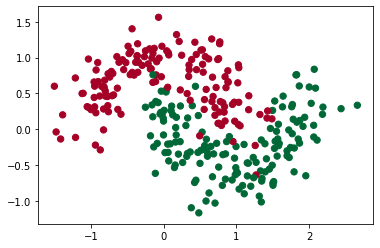

In [3]:
plt.scatter(X[:,0], X[:,1], s = 40, c=y, cmap=plt.cm.RdYlGn)

In [7]:
from P08 import plot_decision_boundary, get_accuracy, get_prediction
import torch
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary

torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)


Following cell shows how to define a neural network with three layers in PyTorch. Function *nn.Linear()* constructs a fully connected layer with arguments *in_features* and *out_features*, which are dimensions of input and output, respectively. *forward* function defines flow of an input tensor *x* and an output tensor which has to be returned. Note that a ReLU and a sigmoid activations are used for the first and second layers.

In [5]:
class MoonMLP(nn.Module):
    def __init__(self):
        super(MoonMLP, self).__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        logits = self.fc3(x) # It doesn't need to apply softmax activation because objective function "torch.nn.CrossEntropyLoss" contains softmax function for the logits. 
        return logits

> torchsummary library shows the number of total parameters and output shape of each layer. It's really helpful when debugging your model.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
moon_mlp_model = MoonMLP() # instanciation
moon_mlp_model.to(device) # allocate model to device (gpu if gpu is available else cpu)
summary(model=moon_mlp_model, input_size=(1,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]              30
            Linear-2                [-1, 1, 10]             110
            Linear-3                 [-1, 1, 2]              22
Total params: 162
Trainable params: 162
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Next, we have to define an optimizer and a loss function. PyTorch provides modules for popular optimizers and loss functions. Here are official documentations for [optim.SGD](https://pytorch.org/docs/master/optim.html#torch.optim.SGD) and [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss).


In [8]:
learning_rate = 0.001

# define the optimizer
optimizer = optim.SGD(moon_mlp_model.parameters(), lr=learning_rate)

# define the loss function
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

Finally, we can train our model. For every iteration, training model includes five steps in PyTorch.
1. Initializing gradients to zero
2. Forward propagation
3. Calculating a loss value
4. Calculating gradients through a backward propagation
5. Updating model parameters 


In [ ]:
total_epoch = 50000
# conver numpy to torch.tensor type
X_tensor = torch.Tensor(X)
y_tensor = torch.LongTensor(y)

X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

tbar = tqdm_notebook(range(total_epoch), total=total_epoch)

# set the model to train-mode. 
moon_mlp_model.train()
for epoch in tbar:
    
    # step 1) initialize gradients to zero 
    optimizer.zero_grad()
    
    # step 2) forward propagation
    output = moon_mlp_model(X_tensor)
    
    # step 3) calculate loss
    loss = criterion(output, y_tensor)
    
    # step 4) calculate gradients through a backward propagation
    loss.backward()
    
    # step 5) update model parameters
    optimizer.step()
    
    # print the progress
    if epoch % 5000 == 4999:
        # set the model to evaluation-mode
        moon_mlp_model.eval() 
        pred = get_prediction(output)
        accuracy = get_accuracy(pred, y_tensor)
    
        desc = '%d-th epoch, loss: %.2f, accuracy: %.2f'%(epoch+1, loss.item(), accuracy)
        tbar.set_description(desc)
        

> *tqdm* makes it convinient to check a progress of 'for or while loop'. 


After 50000 epochs, we find that an accuracy of our model becomes 0.99. Let's visualize a decision boundary similar to the last assignment.

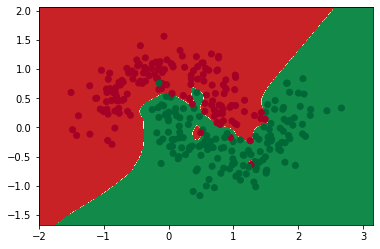

In [0]:
plot_decision_boundary(moon_mlp_model, X, y)

In this example, we briefly studied how to build an MLP model, use pre-defined loss function and optimizer, and train the model via following five steps in PyTorch framework.

---

# Tetris block classification (100 points)


<img src = "https://i.imgur.com/ZwfnL78.png">

Objectives
- Solve Tetris block classification task using MLP and CNNs. Verify the reason why CNNs are better than MLP in tasks of computer vision according to these results. 
- Verify three properties of CNNs. 
    - Robust to translation
    - Sensitive to scale variation
    - Sensitive to rotation variation

## 1. Prepare datasets
For this task, we provide a data generating function which samples different data depending on the arguments: 
- make_tetris_dataset(data_num, batch_size, random_position, random_scale, random_rotation).
- Note that image size and block size are set to 32 and 12 as default. You can find them in P08.py file.

Let's visualize dataset for variable arguments settings. 



In [51]:
from P08 import make_tetris_dataset, visualize_dataset

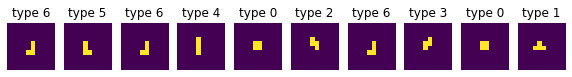

In [52]:
plot_num = 10
random_position = False
random_scale = False
random_rotation = False
dataset = make_tetris_dataset(plot_num, 1, random_position, 
                         random_scale, random_rotation)
visualize_dataset(dataset, plot_num)

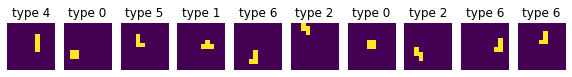

In [53]:
plot_num = 10
random_position = True
random_scale = False
random_rotation = False
dataset = make_tetris_dataset(plot_num, 1, random_position, 
                         random_scale, random_rotation)
visualize_dataset(dataset, plot_num)

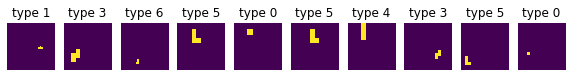

In [54]:
plot_num = 10
random_position = True
random_scale = True
random_rotation = False
dataset = make_tetris_dataset(plot_num, 1, random_position, 
                         random_scale, random_rotation)
visualize_dataset(dataset, plot_num)

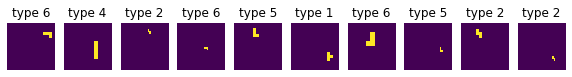

In [55]:
plot_num = 10
random_position = True
random_scale = True
random_rotation = True
dataset = make_tetris_dataset(plot_num, 1, random_position, 
                         random_scale, random_rotation)
visualize_dataset(dataset, plot_num)

## 2. Multi-Layer Perceptrons (MLP)
Train an MLP model to classify the tetris blocks. 
Build the MLP model and train it by using PyTorch framework. We provide the code template for a training, so all you need to do is only building the model without errors. The configurations for the model are as follows:  
- Model & training settings
    - architecture = **Linear(50) - ReLU - Linear(25) - ReLU - Linear(7)**
    > We denote a fully connected layer with m hidden units by Linear(m)
    - loss function = CrossEntropyLoss(reduction='mean')
    - optimizer = AdaGrad(learning_rate=0.01)
- Train set
    - D1 = tetris_dataset(N=2000, batch_size=20, random_position=True, random_scale=False, random_rotation=False)
    - D2 = tetris_dataset(N=500, batch_size=20, random_position=True, random_scale=False, random_rotation=False)
    - D3 = tetris_dataset(N=100, batch_size=20, random_position=True, random_scale=False, random_rotation=False)
    
- Test set
    - E1 = tetris_dataset(N=200, random_position=True, random_scale=False, random_rotation=False)
- Epochs
    - 300 for training on D1
    - 600 for training on D2
    - 1200 for training on D3
- **P2.1) Show results in terms of the number of training samples and the test accuracy. (10 points)** 
    


In [17]:
from P08 import TetrisMLP, train, evaluate

In [50]:
batch_size = 20
random_position = True
random_scale = False
random_rotation = False

train_num = 2000
D1 = make_tetris_dataset(train_num, batch_size, random_position, 
                         random_scale, random_rotation)
train_num = 1000
D2 = make_tetris_dataset(train_num, batch_size, random_position, 
                         random_scale, random_rotation)
train_num = 500
D3 = make_tetris_dataset(train_num, batch_size, random_position, 
                         random_scale, random_rotation)

test_num = 200
E1 = make_tetris_dataset(test_num, batch_size, random_position, 
                         random_scale, random_rotation)

In [ ]:
mlp = TetrisMLP()
mlp.to(device)

learning_rate = 0.05
optimizer = optim.Adagrad(mlp.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

total_epoch = 300
train(model=mlp, optimizer=optimizer, criterion=criterion, 
      train_dataset=D1, total_epoch=total_epoch)

accuracy = evaluate(model=mlp, criterion=criterion, 
                    test_dataset=E1)
print(accuracy)

In [ ]:
mlp = TetrisMLP()
mlp.to(device)

learning_rate = 0.05
optimizer = optim.Adagrad(mlp.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

total_epoch = 600
train(model=mlp, optimizer=optimizer, criterion=criterion, 
      train_dataset=D2, total_epoch=total_epoch)

accuracy = evaluate(model=mlp, criterion=criterion, 
                    test_dataset=E1)
print(accuracy)

In [ ]:
mlp = TetrisMLP()
mlp.to(device)

learning_rate = 0.05
optimizer = optim.Adagrad(mlp.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

total_epoch = 1200
train(model=mlp, optimizer=optimizer, criterion=criterion, 
      train_dataset=D3, total_epoch=total_epoch)

accuracy = evaluate(model=mlp, criterion=criterion, 
                    test_dataset=E1)
print(accuracy)

In [22]:
img_size = 32
summary(mlp, (1, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]          51,250
            Linear-2                   [-1, 25]           1,275
            Linear-3                    [-1, 7]             182
Total params: 52,707
Trainable params: 52,707
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


<span style="color:red"> P2.1) Discuss here </span>


## 3. Convolutional Neural Networks (CNN)

### 3.1 CNN Tutorial
- Model & training settings
    - architecture = **Conv(1,14,12,0) - MaxPool(21) - ReLU - Linear(7)**
    > We denote a convolutional layer with m input feature channels, n output feature channels, k kernel size and p padding number by Conv(m, n, k, p).
    > Also we denote a maxpooling layer with s kernel size by MaxPool(s).
    - loss function = CrossEntropyLoss(reduction='mean')
    - optimizer = AdaGrad(learning_rate=0.05)
- Train set
    - D1 = tetris_dataset(N=2000, batch_size=20 , random_position=True, random_scale=False, random_rotation=False)
    - D2 = tetris_dataset(N=500, batch_size=20, random_position=True, random_scale=False, random_rotation=False)
    - D3 = tetris_dataset(N=100, batch_size=20, random_position=True, random_scale=False, random_rotation=False)
- Test set
    - E1 = tetris_dataset(N=200, random_position=True, random_scale=False, random_rotation=False)
- Epochs
    - 200 for training on D1
    - 400 for training on D2
    - 800 for training on D3
- **P3.1.1) Show results in terms of the number of training samples and the test accuracy. (10 points)**
- **P3.1.2) Describe differences between TetrisMLP model and TetrisCNN1 model in terms of the number of parameters, test accuracy and generalizability. (10 points)**



In [23]:
from P08 import TetrisCNN1

In [ ]:
tetris_cnn1 = TetrisCNN1()
tetris_cnn1.to(device)
learning_rate = 0.05
optimizer = optim.Adagrad(tetris_cnn1.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

total_epoch = 200
train(model=tetris_cnn1, optimizer=optimizer, criterion=criterion, 
      train_dataset=D1, total_epoch=total_epoch)

accuracy = evaluate(model=tetris_cnn1, criterion=criterion, 
                    test_dataset=E1)
print(accuracy)

In [ ]:
tetris_cnn1 = TetrisCNN1()
tetris_cnn1.to(device)
learning_rate = 0.05
optimizer = optim.Adagrad(tetris_cnn1.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

total_epoch = 400
train(model=tetris_cnn1, optimizer=optimizer, criterion=criterion, 
      train_dataset=D2, total_epoch=total_epoch)

accuracy = evaluate(model=tetris_cnn1, criterion=criterion, 
                    test_dataset=E1)
print(accuracy)

In [ ]:
tetris_cnn1 = TetrisCNN1()
tetris_cnn1.to(device)
learning_rate = 0.05
optimizer = optim.Adagrad(tetris_cnn1.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

total_epoch = 800
train(model=tetris_cnn1, optimizer=optimizer, criterion=criterion, 
      train_dataset=D3, total_epoch=total_epoch)

accuracy = evaluate(model=tetris_cnn1, criterion=criterion, 
                    test_dataset=E1)
print(accuracy)

In [27]:
img_size = 32
summary(tetris_cnn1, (1, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 21, 21]           2,030
            Linear-2                    [-1, 7]             105
Total params: 2,135
Trainable params: 2,135
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.01
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


<span style="color:red"> P3.1.1) Discuss here </span>

<span style="color:red"> P3.1.2) Discuss here </span>




### 3.2 Build a deeper CNN model
Build a new CNN model following below architecture by modifying **TetrisCNN2** class in P08.py.  It is deeper model than TetrisCNN1. 
- Model & training settings
    - structure = **Conv(1,5,3,1) - MaxPool(2) - ReLU - Conv(5,10,3,1) - MaxPool(2) - ReLU - Conv(10,10,3,1) - MaxPool(2) - ReLU - Conv(10,10,3,1) - MaxPool(2) - ReLU - Conv(10,10,3,1) - MaxPool(2) - ReLU - Linear(10) - ReLU - Linear(7)**
    - loss function = CrossEntropyLoss(reduction='mean')
    - optimizer = AdaGrad(learning_rate=0.05)
    
**P3.2.1) Measure test accuracies for E1 after training TetrisCNN2 on D1. (20 points)**

In [ ]:
from P08 import TetrisCNN2

In [ ]:
# solve here

img_size = 32
summary(tetris_cnn2, (1, img_size, img_size))

<span style="color:red"> P3.2.1) Discuss here </span>


## 4. Properties of CNNs

### 4.1 Robust to translation
- Train set
    - D4 = tetris_dataset(N=1000, batch_size=20, random_position=False, random_scale=False, random_rotation=False)
- Test set
    - E1 = tetris_dataset(N=200, random_position=True, random_scale=False, random_rotation=False)

**P4.1.1) Confirm that CNN is more translation-invariant than MLP by comparing test accuracies of TetrisCNN1 to TetrisMLP model. Discuss the reason why the TetrisCNN1 model has better performance despite having fewer model parameters than MLP. (30 points)**

> Hint ; Think about properties of convolution operation.



In [57]:
batch_size = 20
random_position = False
random_scale = False
random_rotation = False

train_num = 1000
D4 = make_tetris_dataset(train_num, batch_size, random_position, 
                         random_scale, random_rotation)

In [ ]:
# solve here

<span style="color:red"> P4.1.1) Discuss here </span>


### 4.2 Sensitive to scale and rotation variation.
**P4.2.1) Verify that TetrisCNN1 model is sensitive to scale and rotation variation. Construct test sets using make_tetris_dataset function to verify them. Discuss the results and how to overcome those sensitivities. (20 points)**
- Note that:
    - random_scale=True : block_sizes are uniformly selected from [4, 8, 12]
    - random_rotation=True : rotations are uniformly selected from [0, 90, 180, 270]
    
**BONUS; P4.2.2) Confirm your idea to overcome those sensitivities of CNNs. Feel free to implement your idea in this .ipynb file or P08.py. (5 extra-points)**

In [0]:
# solve here

<span style="color:red"> P4.2.1) Discuss here </span>


<span style="color:red"> P4.2.2) </span>
